# Strain from Psi4

Things to be fixed  
1. Change the strain plots to subplots of strain and psi4

In [1]:
from nrutils import scsearch, gwylm, alert
import numpy as np
import os, shutil, sys

import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')


import multiprocessing as mp

In [2]:
#Record initial stdout to switch on and off the verbose output of functions
old_stdout = sys.stdout
py3 = sys.version_info[0] > 2 #creates boolean value for test that Python major version > 2

In [3]:
#Define class of colors
class bcolors:
    HEADER = '\x1b[33m'
    OKBLUE = '\x1b[36m'
    OKGREEN = '\x1b[32m'
    WARNING = '\x1b[31m'
   
    ENDC = '\x1b[0m'
    #BOLD = '\033[1m'
    #UNDERLINE = '\033[4m'
    

def message(msg):
    print(msg)

#To intake input from user
def usercall(msg):
    if py3:
      response = input(msg)
    else:
      response = raw_input(msg)
    return response


# Output Strain data in text files
def write_strdata(data, outfile):
    strain = open(outfile,'w')
    hdr = "#Time \t hplus \t hcross \t amp \t phase \n"
    np.savetxt(strain, data, header=hdr, newline="\n", delimiter="\t" )
    strain.close()


#Move waveform directory to final location outdir
def movedir(simname, outdir, wfdir ):
    
    if os.path.exists(outdir+"/"+ simname):
        response = usercall(bcolors.WARNING+"%s"%simname+bcolors.ENDC+ " >> Waveform directory %s already exists at %s. \
        Do you want to delete the existing directory? (Yes/No)"%(simname, outdir))
       
        if response=="Yes":
            shutil.rmtree(os.path.join(outdir,simname))
            shutil.move(wfdir, outdir)
            print(bcolors.OKGREEN+"%s"%simname + bcolors.ENDC + " >> Directory moved to %s \n"%outdir)

        elif response=="No":
            print(bcolors.OKGREEN+"%s"%simname + bcolors.ENDC + " >> Directory not moved to %s \n"%outdir)

        else:
            print(bcolors.OKGREEN+"%s"%simname + bcolors.ENDC + " >> Invalid Response. Please Try Again  \n")
            movedir(simname, outdir, wfdir)
            
    else:
        print(bcolors.OKGREEN+"%s"%simname + bcolors.ENDC + " >> Directory moved to %s \n"%outdir)
        shutil.move(wfdir, outdir)
        

In [4]:
#Define simulation type based on spins - used to categorise and move output directories
def simulation_type(spin1, spin2):

    if (np.count_nonzero(spin1) ==0 and np.count_nonzero(spin2)==0):
        simtype = 'non-spinning'
    elif (np.count_nonzero(spin1[0:2])>0 or np.count_nonzero(spin2[0:2])>0) :
        simtype = 'precessing'
    else:
        simtype = 'aligned-spins'

    return simtype

In [5]:
# Disable Print
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore Print
def enablePrint():
    sys.stdout = old_stdout

In [ ]:
def simulation_name(waveform):

    waveform_name = waveform.__dict__['simname']
    wf_junkrad = 'wf_junkrad.txt'
    
    wfdata = np.genfromtxt(wf_junkrad, dtype=None, comments='#', usecols=(0,1), skip_header=1, delimiter = '\t', names = ('GTID', 'simname'))
    GTname, wfname = wfdata['GTID'], wfdata['simname']

    if np.array(np.where(wfname==waveform_name)).size==0:
        raise NameError('%s >> GT simulation name incorrectly listed in wf_junkrad.txt. Please check the file.'%waveform_name)
    elif np.array(np.where(wfname==waveform_name)).size>1:
        raise NameError('{} >> Multiple occurences of GT simulation - {} in wf_junkrad.txt - Please check the file.'.format(waveform_name, file_name))
    else: 
        idx = (np.where(wfname == waveform_name))[0][0]
        return GTname[idx]

In [ ]:
def ComputeStrain(waveforms, outdir, lmax, verbose=True):

    simname = waveforms.__dict__["simname"]
    
    #Search the waveform
    tempdir = "/localdata/bkhamesra3/LIGO_Waveforms/Waveform_Tests"
    wf = waveforms      #scsearch(keyword=waveforms, institute='gt', verbose=True)
    wfdir = os.path.join(tempdir, wf.__dict__['simname'])
    numreldir = '/nethome/numrel/datafiles/Waveforms'
   
    #Create the necessary directories
    strain_dir = os.path.join(wfdir,"data/Strain")
    strfigdir = os.path.join(wfdir,"figures/strain_figures")
    datadir = os.path.join(wfdir,"data")
    figdir = os.path.join(wfdir,"figures")
    
    if not os.path.exists(strain_dir):
        os.makedirs(strain_dir)
    if not os.path.exists(strfigdir):
        os.makedirs(strfigdir)
    
    
    message(bcolors.OKGREEN + "%s"%simname + bcolors.ENDC + " >> Directory constructions finished \n")

    #Find the maximum l multipole mode - assumption ylm_88 is present if lmax=8 or ylm_66 file is present if lmax=6
    ylm_66 = os.path.join(os.path.join(numreldir, wf.__dict__['relative_simdir']), 'Ylm_WEYLSCAL4::Psi4r_l6_m6_r75.00.asc')
    ylm_88 = os.path.join(os.path.join(numreldir, wf.__dict__['relative_simdir']), 'Ylm_WEYLSCAL4::Psi4r_l8_m8_r75.00.asc')

    mp_ylm_66 = os.path.join(os.path.join(numreldir, wf.__dict__['relative_simdir']), 'mp_WeylScal4::Psi4i_l6_m6_r75.00.asc')
    mp_ylm_88 = os.path.join(os.path.join(numreldir, wf.__dict__['relative_simdir']), 'mp_WeylScal4::Psi4i_l8_m8_r75.00.asc')
    
    if not os.path.exists(ylm_88):
        if not os.path.exists(mp_ylm_88):
            lmax=6

    if not os.path.exists(ylm_66):
        if not os.path.exists(mp_ylm_66):
            lmax=2

    lm = []
    for l in range(2,lmax+1):
        for m in range(-l,l+1):
            lm.append((l,m))
    
   

    #Costruct the Strain bundle
    blockPrint()
    y = gwylm(wf, lm=lm, clean=True);                  
    #y_20 = gwylm(wf, lm=[2,0], clean=True, w22=)
    enablePrint()
    
    message(bcolors.OKGREEN+"%s"%simname + bcolors.ENDC +  " >> Strain Computation finished \n")
    
    
    #Copy the relevant files
    simdir = y.__dict__['simdir']
    simname = y.__dict__['simname']
    

    def copyfile(filename):
        filepath = os.path.join(simdir, filename)
        if os.path.exists(filepath):
            shutil.copy(filepath, datadir)
        else:
            print(bcolors.WARNING+"%s >> Warning"%simname  +" - %s file was not found \n"%(filename)+ bcolors.ENDC)

    

    files = ["BH_diagnostics.ah1.gp","BH_diagnostics.ah2.gp", "BH_diagnostics.ah3.gp", (simname+".par"),"hn_mass_spin_0.asc", "hn_mass_spin_1.asc", "ihspin_hn_0.asc", "ihspin_hn_1.asc", "ihspin_hn_2.asc", 
    "ihspin_hn_3.asc", "ihspin_hn_4.asc", "ShiftTracker0.asc", "ShiftTracker1.asc"]
    
    for f in files:
        copyfile(f)

    message(bcolors.OKGREEN+"%s"%simname + bcolors.ENDC + " >> Required Files copied \n")
    
    
    #Compute the metadata
    s1 = y.__dict__["S1"]
    s2 = y.__dict__["S1"]

    simtype=simulation_type(s1, s2)

      
    
    #Compute the strain plots
    for l,m in lm:
        [time, hp, hx] = y.lm[l,m]['strain'].wfarr.T
        [psitime, re, im] = y.lm[l,m]['psi4'].wfarr.T
        #if l==2 and m==0:
        #     [time, hp, hx] = y_20.lm[l,m]['strain'].wfarr.T
                
        data = np.column_stack((time, hp, hx))
        write_strdata(data, os.path.join(strain_dir,"Strain_l%d_m%d.asc"%(l,m)))
        
        fig, (ax1, ax2) = plt.subplots(2,1)
        ax1.plot(time, hp, 'b', label='h+')
        ax1.plot(time, hx, color='darkorange', label='hx')
        
        ax2.plot(psitime, re, 'b', label='Real')
        ax2.plot(psitime, im, color='darkorange', label='Imaginary')
        ax1.set_ylabel('Strain')
        ax2.set_ylabel('Psi4')
        ax1.set_xlabel('Time')
        ax2.set_xlabel('Time')
        ax1.set_title("Strain - (%d,%d) Mode"%(l,m))
        ax1.legend()
        ax2.legend()
        plt.savefig(os.path.join(strfigdir, "Strain_%d%d.png"%(l,m)), dpi=500)
        plt.close()

    print(bcolors.OKGREEN+"%s"%simname + bcolors.ENDC + " >> Strain plots created \n")
    
    #Plot of 2,0 mode - 
    del time, hp, hx
    time, hp, hx = y.lm[2,0]['strain'].wfarr.T
    plt.plot(time, hp, 'b', label='h+')
    plt.plot(time, hx, color='darkorange', label='hx')
    plt.ylabel('Strain')
    plt.xlabel('Time')
    plt.title("Strain - (%d,%d) Mode"%(2,0))
    plt.legend()
    plt.show()
    plt.close()
        
        
    #Update the output directory based on spins
    if simtype=="non-spinning":
        outdir = os.path.join(outdir, "NonSpinning")
    elif simtype=="aligned-spins":
        outdir = os.path.join(outdir, "AlignedSpin")
    else:
        outdir = os.path.join(outdir, "Precessing")
   
    movedir(simname, outdir, wfdir)
    

In [ ]:
lmax = 8

outdir = '/nethome/numrel/datafiles/Finalized_Waveforms/Waveform_files/New_BK'
if not os.path.exists(outdir):
    #os.makedirs(outdir)
    msg = "Output directory %s not found"%outdir
    raise ValueError (msg)

In [ ]:
blockPrint()
waveform = scsearch(verbose=True,institute='gt')
pool = mp.Pool(processes=4)
enablePrint()
for wf in waveform:
        print(bcolors.HEADER+"ComputeStrain"+bcolors.ENDC + " >> Waveform - %s " %wf.__dict__["simname"])
        ComputeStrain(wf, outdir, lmax)
                                                

In [6]:
sim = scsearch(keyword="D11_q1.00_a0.00_0.20_m160", verbose=True,institute='gt')[0]
simname = sim

print(bcolors.OKGREEN+"%s"%simname + bcolors.ENDC + " >> Strain plots created \n")
    

(scsearch)>> Found institute (='gt') keyword.
(scsearch)>> Found keyword (='D11_q1.00_a0.00_0.20_m160') keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][bradwr] HR-series: 2chi0.20-sa-q1.00	(D11_q1.00_a0.00_0.20_m160)

<nrutils.core.nrsc.scentry instance at 0x7f81c51b8fc8> >> Strain plots created 



In [9]:
y = gwylm(simname, lm=[2,2], clean=True);                  
time, hp, hx = y.lm[2,2]['strain'].wfarr.T
phi = y.lm[2,2]['strain'].phi

(validate!)>> Multiple catalog directories found. We will scan through the related list, and then store first the catalog_dir that the OS can find.
(validate!)>> Selecting "/nethome/numrel/datafiles/Waveforms/"
/nethome/numrel/datafiles/Waveforms/HR-series/q1/D11_q1.00_a0.00_0.20_m160/
(load)>> Imposing a default padding of 3 to the data.


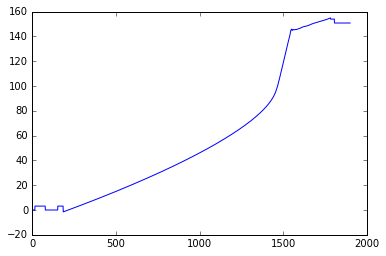

In [10]:
plt.plot(time, phi)
plt.show()